# Assignment 2: Hypothesis Testing

*Due*: Wed, Nov 13, 2019 in class


## Motivation
In a standard randomized control trial, our null hypothesis is often trivial---nothing happens, no difference in the mean, no difference in the relative ranking. In this assignment, we look to generalize this idea to compare observed data against an assumed statistical model. That is, could the observed data plausibly be generated from the known model.


An air shower is a cascade of ionized particles and electromagnetic radiation produced in the atmosphere when a primary cosmic ray (i.e. one of extraterrestrial origin) enters the atmosphere. When a particle, which could be a proton, a nucleus, an electron, a photon, or (rarely) a positron, strikes an atom's nucleus in the air it produces many energetic hadrons. We have a detector that observes particles that reach a ground station and measures the particle energy and arrival time.

## Model and Data
We have the following theoretical model to describe particle behavior. The energy of each particle is drawn independent of arrival time from a [Gamma Distribution](https://en.wikipedia.org/wiki/Gamma_distribution). The particles arrive as a [Poisson process](https://en.wikipedia.org/wiki/Poisson_point_process). We have the following simulator:

In [236]:
import numpy as np
import pandas as pd

def simulate_burst(total):
    """Simulates a trial of total # of particles returns
       a dataframe with two columns one with observed time (in microsecs)
       and one with the energy in kilojoules.
    """
    t = 0
    data = []
    for trial in range(total):
        t += np.random.exponential(scale=1.0)
        obs = np.random.gamma(2.15,1.96, 1)[0]
        
        data.append({'otime_us':t, 'energy_kj':obs})
    
    return pd.DataFrame(data)

In addition to the simulator, you are given a daset of real observations [download](https://raw.githubusercontent.com/sjyk/cmsc21800/master/part.csv). You will write a function to load this dataset into a pandas dataframe. The dataset contains some missing values, the function should drop all rows with any missing values (i.e., NaN)

In [237]:
def load_data(filename):
    """
       Input: a csv file of airburst observations
       Output: a pandas dataframe with no NaNs
    """
    data = pd.read_csv(filename, delim_whitespace=True)
    data.dropna(inplace=True)
    
    # Invert column order to match the simulation's style
    data = data.iloc[:, ::-1]

    return data

## Pre-Processing

Before, we begin testing, we show analyze the data for potential problems.

**Q1.** *Compare particle energies generated from the simulator and the real data. If they do differ, explain how.*

In [257]:
# Load the real data and describe it
data = load_data("part.csv")

data.describe()

,energy_kj,otime_us
count,996.000000,996.000000
mean,4.385513,498.045568
std,33.995733,287.746567
min,-246.000000,0.940633
25%,1.940490,249.466874
50%,3.559943,497.730739
75%,5.958558,746.774461
max,286.000000,998.868280


In [260]:
# Make a simulation of the same length as our data and describe it
simulation = simulate_burst(data['energy_kj'].size)

simulation.describe()

,energy_kj,otime_us
count,996.000000,996.000000
mean,4.250477,488.577829
std,2.995857,276.608686
min,0.018264,0.478189
25%,2.031148,249.458229
50%,3.565184,492.903000
75%,5.690303,725.799731
max,26.153971,962.639698


As we can see from the summaries of both the real and the simulated data above, we can clearly say that the particle energies generated from both are highly similar to each other. This is easily seen from looking at the mean and the percentile values of both descriptions. It is worth noting that the min, max, and consequently standard deviation values differ substantially, but that can be explained through the minimum and maximum values being *significant outliers* in the dataset. Apart from this difference, they seem to be close to each other.

**Q2.** *Your engineers tell you that all energy readings should be positive. Are there any negative values in either of the datasets? If so, is there any unexpected pattern to those values in terms of times they occur or values they take on?*

In [240]:
# First, let's look at the original dataset
data_neg = data[data['energy_kj'] < 0]

print('Number of negative values in the original dataset: ' + \
      str(data_neg['energy_kj'].size))

data_neg

Number of negative values in the original dataset: 50


,energy_kj,otime_us
1,-128.0,1.559228
60,-139.0,60.057136
78,-104.0,78.842368
90,-24.0,90.386515
91,-68.0,91.418192
97,-89.0,97.516804
99,-85.0,99.581593
109,-32.0,109.091903
139,-3.0,139.651419
140,-96.0,140.264270


As we can see, the original dataset definitely has negative outliers. Now, let's visualize the data on a chart in order to better understand the spread of the outliers.

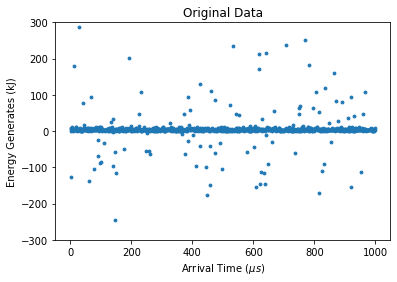

In [241]:
import matplotlib.pyplot as plt

# We know from the description above that the minimum value is -246 and the maximum value is 286,
# so our y scale is built around such range
data_plot = data.plot.scatter(title = 'Original Data' , \
                              x = 'otime_us', y = 'energy_kj', \
                              ylim = (-300, 300), s = 8)
data_plot.set_xlabel('Arrival Time ($\mu s$)')
data_plot.set_ylabel('Energy Generates (kJ)')

plt.show()

From the scatter plot above, it seems like the negative energy reading distribution is pretty random. Furthermore, it seems like the same randomness applies to the really high values in the data set as well. Apart from these high or low outliers, the main spread of the value seems to be between a range of $[0, \sim15)$.

In [242]:
# Next, let's look at the simulation dataset
sim_neg = simulation[simulation['energy_kj'] < 0]

print('Number of negative values in the simulated dataset: ' + \
      str(sim_neg['energy_kj'].size))

Number of negative values in the simulated dataset: 0


As we can see, the simulated data set does not have any negative outliers (i.e. all of the energy data is $\geq 0$). We can further confirm this by plotting our data:

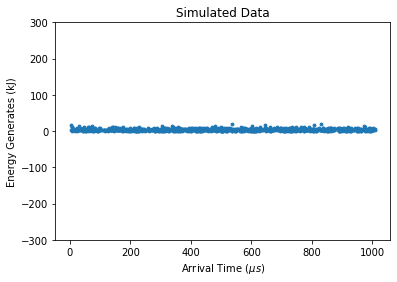

In [243]:
sim_plot = simulation.plot.scatter(title = 'Simulated Data', \
                                   x = 'otime_us', y = 'energy_kj', \
                                   ylim = (-300, 300), s = 8)
sim_plot.set_xlabel('Arrival Time ($\mu s$)')
sim_plot.set_ylabel('Energy Generates (kJ)')

plt.show()

**Q3.** *Are there any other energy readings that are suspect in the real dataset? Roughly what fraction of values are suspect?*

As we can see from the plot of the original dataset above, we seem to have some data points that are too high in comparison to the general trend of the data. Similar to the negative outliers, the distribution of these positive data points seem random as well.

From this, we can make certain calculations in order to understand the fraction of all outliers in our original dataset (i.e. both negative and positive outliers). As these outliers seem to be pretty distant from the general trend of the data points in terms of quantity, and as their spread does not point to any significant occurrence, we can simply filter them out from the dataset through percentile calculations.

To understand the fraction of values that are positive outliers, we can filter out all data points above the 95% percentile and below the 5% percentile:

In [244]:
filtered_data = data[(data['energy_kj'] < data['energy_kj'].quantile(0.95)) & \
                     (data['energy_kj'] > data['energy_kj'].quantile(0.05))]

print('Size of the original dataset: ' + str(data['energy_kj'].size))
print('Size of the original dataset without outliers: ' + \
      str(filtered_data['energy_kj'].size))

outlier_count = data['energy_kj'].size - filtered_data['energy_kj'].size

print('\nFraction of suspect values = ' + str(outlier_count) + ' / ' + \
      str(data['energy_kj'].size) + ' = ' + str(outlier_count / data['energy_kj'].size))

Size of the original dataset: 996
Size of the original dataset without outliers: 896

Fraction of suspect values = 100 / 996 = 0.10040160642570281


To make sure that our dataset without the outliers actually makes sense, let's visualize both the filtered dataset and also the simulation dataset and make another comparison:

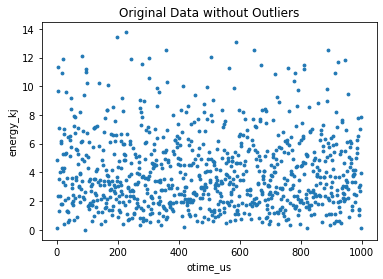

In [245]:
# Filtering out data points that do not fit into the %5 to %95 percentile range
filtered_plot = filtered_data.plot.scatter(title = 'Original Data without Outliers', \
                                           x = 'otime_us', y = 'energy_kj', s = 8)

plt.show()

As the simulated dataset doesn't seem to have any outliers, let's plot it again, this time with a smaller y-axis scale instead:

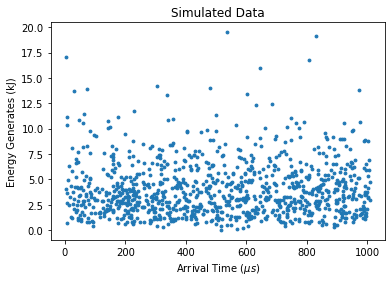

In [246]:
new_sim_plot = simulation.plot.scatter(title = 'Simulated Data', \
                                       x = 'otime_us', y = 'energy_kj', s = 8)
new_sim_plot.set_xlabel('Arrival Time ($\mu s$)')
new_sim_plot.set_ylabel('Energy Generates (kJ)')

plt.show()

As we can see, our filtered dataset and simulation dataset are visually much more similar than before. As a final check, we can describe the filtered dataset and compare it to the simulation description above in order to confirm that our conclusion makes sense:

In [247]:
filtered_data.describe()

,energy_kj,otime_us
count,896.000000,896.000000
mean,4.106537,498.007822
std,2.621080,288.529457
min,0.000000,0.940633
25%,2.100952,249.466874
50%,3.559943,497.730739
75%,5.581678,745.810192
max,13.748464,998.868280


Based on your answers to Q1, Q2, Q3, write a function that cleans the real data by removing all problematic observations. 

In [248]:
def clean(df):
    """
       Input: a dataframe of a mix of erroneous and correct observations 
       Output: a dataframe with only the correct observations
    """
    # Remove everything below the 5% percentile and above the 95% percentile
    # i.e. discard all outliers from the dataset
    clean_df = df[(df['energy_kj'] < df['energy_kj'].quantile(0.95)) & \
                     (df['energy_kj'] > df['energy_kj'].quantile(0.05))]
    
    return clean_df

## Comparing the Energies
Now, we will compare the particle energies from the simulated data and the real data. Fill in the following hypothesis tests. *Be reasonable about this.* You may not import methods from statistics packages that perform the test for you.

In [385]:
import scipy

def z_test_energy(simulated, real):
    """
       Input: a dataframe of simulated observations, a dataframe of real observations 
       Output: a p-value based on the two-sample z-test
    """
    z = ((simulated['energy_kj'].mean() - real['energy_kj'].mean()) - 0) / \
    np.sqrt(((simulated['energy_kj'].std() ** 2) / simulated['energy_kj'].size) \
              + ((real['energy_kj'].std() ** 2) / real['energy_kj'].size))

    # Two-tailed p value being returned. Also, as this step is basically looking up
    # the z value on a p table, I had to import scipy to convert the z-value to
    # a p-value. As seen above, no statistics packages were used for the z-value
    # calculation.
    return scipy.stats.norm.sf(abs(z)) * 2

    
def rs_test_energy(simulated, real):
    """
       Input: a dataframe of simulated observations, a dataframe of real observations 
       Output: a p-value based on the two-sample rank-sum test using the normal approximation
    """
    simulated['type'] = 'sim'
    real['type'] = 'real'
    
    merged = pd.concat([simulated, real])
    merged.sort_values(by=['energy_kj'], inplace=True)
    merged['rank'] = range(1, merged['energy_kj'].size + 1)
    
    ranked_sim = merged.loc[merged['type'] == 'sim']
    
    sim_sum = ranked_sim['rank'].sum()
    
    sim_size = simulated['energy_kj'].size
    real_size = real['energy_kj'].size
    
    std_error = np.sqrt((sim_size * real_size * (sim_size + real_size + 1)) / 12)
    
    z = (sim_sum - ((sim_size * (sim_size + real_size + 1)) / 2)) / std_error

    # Two-tailed p value being returned. Also, as this step is basically looking up
    # the z value on a p table, I had to import scipy to convert the z-value to
    # a p-value. As seen above, no statistics packages were used for the z-value
    # calculation.
    return scipy.stats.norm.sf(abs(z)) * 2


# Get the data
simulate_data = simulate_burst(10000)
real_data =  clean(load_data('part.csv'))
print('Two-Sample Z-Test: ', z_test_energy(simulate_data, real_data))
print('Rank Sum Test: ', rs_test_energy(simulate_data, real_data))

Two-Sample Z-Test:  0.29858255355383323
Rank Sum Test:  0.8521456928357952


There are a few parameters here that we selected: (1) how much data to simulate, and (2) we cleaned the real dataset prior to testing. Evaluate the effects of these choices.

**Q1.** *Would it be beneficial to simulate 1e6 data points rather than the 10000 used above, why or why not?*

In [371]:
small_sim = simulate_burst(10000)
big_sim = simulate_burst(int(1e6))

print('Two-Sample Z-Test with Small Simulation: ', z_test_energy(small_sim, real_data))
print('Rank Sum Test with Small Simulation: ', rs_test_energy(small_sim, real_data))

print('\nTwo-Sample Z-Test with Big Simulation: ', z_test_energy(big_sim, real_data))
print('Rank Sum Test with Big Simulation: ', rs_test_energy(big_sim, real_data))

Two-Sample Z-Test with Small Simulation:  0.11425766793543242
Rank Sum Test with Small Simulation:  0.6110777879925923

Two-Sample Z-Test with Big Simulation:  0.21850038377052206
Rank Sum Test with Big Simulation:  0.7614267610624067


As we can see, the p-values generated through the tests using the simulations with 1e6 data points are higher than those generated using the simulations with 10000 data points. This phenomenon makes sense when we consider the **Law of Large Numbers**, which states that "averages of independent random variables tend towards the expected value"; i.e. our simulation tends more towards the expected value as the trial size increases.

**Q2.** *Do the p-values change if you did not clean the dataset? Are both tests equally sensitive to the dirty data?*

In [372]:
dirty_data =  load_data('part.csv')

print('Two-Sample Z-Test with Clean Data: ', z_test_energy(simulate_data, real_data))
print('Two-Sample Z-Test with Dirty Data: ', z_test_energy(simulate_data, dirty_data))

print('\nRank Sum Test with Clean Data: ', rs_test_energy(simulate_data, real_data))
print('Rank Sum Test with Dirty Data: ', rs_test_energy(simulate_data, dirty_data))

Two-Sample Z-Test with Clean Data:  0.3057850951524568
Two-Sample Z-Test with Dirty Data:  0.8639713714863547

Rank Sum Test with Clean Data:  0.8782315387765063
Rank Sum Test with Dirty Data:  0.8831823050445935


Yes, the p-values change if we do not clean the data, as seen from the results above. The two-sample z-test seems to be a lot more sensitive to dirty data than the rank sum test, which seems to not have been affected that much in comparison.

## Comparing the Arrival Times
So far, we have only tested the particle energies. Another important aspect of our model is the arrival process (i.e., the times). 

**Q1.** *Describe a hypothesis test that evaluates whether the arrival process significantly differs in the simulator from the observed data.*

First, we can add a new column to our dataframes for the time difference between each arrival observation. Then, we can use the two-sample z-test to see if the time differences between the real data and the simulated data has a significant enough difference. If our p-value is large enough, we can't reject the null hypothesis and state that there is no significant difference between our expected values.

**Q2.** *Do your pre-processing choice above change? Why or why not?*

Yes, our pre-processing choice changes because even though some of our energy calculations could be considered as outliers, our overall arrival time cannot produce outliers, as we seem to have set intervals between each data point reading. Thus, independent of the energy reading, the time readings must be kept in for testing the arrival process, which means that no "cleanup" of the real data is needed.

In [389]:
def test_arrival_process(simulated, real):
    """
       Input: a dataframe of simulated observations, a dataframe of real observations 
       Output: a p-value that determines the difference between the arrival processes
    """
    
    simulated['t_diff'] = simulated['otime_us'].shift(-1) - simulated['otime_us']
    real['t_diff'] = real['otime_us'].shift(-1) - real['otime_us']
    
    simulated.dropna(inplace=True)
    real.dropna(inplace=True)

    z = ((simulated['t_diff'].mean() - real['t_diff'].mean()) - 0) / \
    np.sqrt(((simulated['t_diff'].std() ** 2) / simulated['t_diff'].size) \
              + ((real['t_diff'].std() ** 2) / real['t_diff'].size))

    # Two-tailed p value being returned. Also, as this step is basically looking up
    # the z value on a p table, I had to import scipy to convert the z-value to
    # a p-value. As seen above, no statistics packages were used for the z-value
    # calculation.
    return scipy.stats.norm.sf(abs(z)) * 2

In [392]:
print('Two-Sample Z-Test for the Arrival Process: ', test_arrival_process(simulate_data, dirty_data))

Two-Sample Z-Test for the Arrival Process:  0.7297467618296201


As seen from the p-value result above, we don't have a significant difference between our simulated and real datasets. Thus, we don't reject the null hypothesis.